In [83]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import time

In [67]:
glucose_path = "../data/blood-glucose.csv"
motion_path = "../data/motion.tsv"
TIMESPAN_H = 48
INTERVAL_M = 15
WALKING_COLUMN = 2
TRAIN_RATIO = 0.7

In [13]:
df_glucose = pd.read_csv(glucose_path, header=None)
df_motion = pd.read_csv(motion_path, sep='\t', header=None)

df_glucose[0] = df_glucose[0].apply(lambda elem: pd.to_datetime(elem))
df_motion[0] = df_motion[0].apply(lambda elem: pd.to_datetime(elem))

In [14]:
start_date_motion = df_motion[0].min().floor(str(INTERVAL_M)+'T')
start_date_glucose = df_glucose[0].min().floor(str(INTERVAL_M)+'T')

end_date_motion = df_motion[0].max()
end_date_glucose = df_glucose[0].max()

if start_date_motion > start_date_glucose:
    start_date = start_date_motion
else:
    start_date = start_date_glucose
if end_date_motion > end_date_glucose:
    end_date = end_date_glucose
else:
    end_date = end_date_motion
    
all_intervals = pd.date_range(start_date, end_date, freq=str(INTERVAL_M)+'T')
nr_of_elems = int(TIMESPAN_H*60/float(INTERVAL_M))

In [56]:
def get_motion_hist():
    start_time = time.time()
    motion_array = np.zeros(shape=(len(all_intervals)-nr_of_elems,))
    i = 0
    for timestamp in all_intervals:
        
        t_index = all_intervals.get_loc(timestamp)
        if t_index < nr_of_elems:
            continue
  
        

        if i%50==0:
            print('measurement', i, '/', len(all_intervals)-nr_of_elems, '(', round(time.time()-start_time, 3),'sec. )')
            start_time = time.time()

        end_interval = timestamp
        start_interval = all_intervals[t_index-nr_of_elems]
        mask = (df_motion[0] > start_interval) & (df_motion[0] <= end_interval)

        # get rows within interval
        selected_rows = df_motion.loc[mask]
        
        time_walking = 0
        walking = False
        start_walking = None
        end_walking = None

        for index, row in selected_rows.iterrows():
            if row[WALKING_COLUMN] == 1:
                start_walking = row[0]
                walking = True
            elif row[WALKING_COLUMN] == 0 and walking:
                end_walking = row[0]
                duration = (end_walking-start_walking).total_seconds() / 60. / 60.
                time_walking += duration
                walking = False
        if walking:
            duration = (end_interval-start_walking).total_seconds() / 60. / 60.
            time_walking += duration

        motion_array[i] = time_walking
        
        i += 1
    motion_array = motion_array[:i]
    return motion_array

In [53]:
def get_glucose_devs():
    gluc_array = np.zeros(shape=(len(all_intervals)-nr_of_elems,))
    i = 0
    for timestamp in all_intervals:

        t_index = all_intervals.get_loc(timestamp)
        if t_index < nr_of_elems:
            continue
            
        if i%100==0:
            print('row', i, '/', len(all_intervals)-nr_of_elems)

        end_interval = timestamp
        start_interval = all_intervals[t_index-nr_of_elems]
        mask = (df_glucose[0] > start_interval) & (df_glucose[0] <= end_interval)

        # get rows within interval
        selected_rows = df_glucose.loc[mask]
        
        # Fill in missing values by mean
        # selected_rows[1].fillna(selected_rows[1].mean())
        
        glucose_std_dev = selected_rows[1].std()
        gluc_array[i] = glucose_std_dev
        
        i += 1
    gluc_array = gluc_array[:i]
    return gluc_array

In [54]:
gluc_array = get_glucose_devs()

row 0 / 841
row 100 / 841
row 200 / 841
row 300 / 841
row 400 / 841
row 500 / 841
row 600 / 841
row 700 / 841
row 800 / 841


In [57]:
motion_array = get_motion_hist()

measurement 0 / 841 ( 0.002 sec. )
measurement 50 / 841 ( 10.824 sec. )
measurement 100 / 841 ( 11.816 sec. )
measurement 150 / 841 ( 12.828 sec. )
measurement 200 / 841 ( 12.384 sec. )
measurement 250 / 841 ( 10.815 sec. )
measurement 300 / 841 ( 10.9 sec. )
measurement 350 / 841 ( 8.24 sec. )
measurement 400 / 841 ( 7.391 sec. )
measurement 450 / 841 ( 6.258 sec. )
measurement 500 / 841 ( 4.07 sec. )
measurement 550 / 841 ( 4.98 sec. )
measurement 600 / 841 ( 5.013 sec. )
measurement 650 / 841 ( 6.708 sec. )
measurement 700 / 841 ( 7.285 sec. )
measurement 750 / 841 ( 7.484 sec. )
measurement 800 / 841 ( 8.22 sec. )


In [65]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

[[1.         0.60345071]
 [0.60345071 1.        ]]


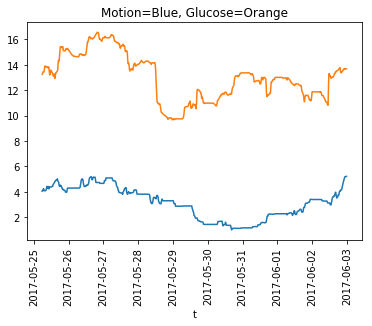

In [110]:
x_motion = motion_array[:]
x_gluc = gluc_array[:]

print(np.corrcoef(x_motion, x_gluc))

plt.figure()
plt.plot(all_intervals[nr_of_elems:nr_of_elems+len(x_motion)], x_motion)
plt.title("Motion=Blue, Glucose=Orange")
plt.xlabel("t")
plt.plot(all_intervals[nr_of_elems:nr_of_elems+len(x_gluc)], x_gluc)
plt.xticks(rotation='vertical')

x_motion, x_gluc = unison_shuffled_copies(x_motion, x_gluc)

train_motion = x_motion[:int(len(x_motion)*TRAIN_RATIO)]
train_motion = np.reshape(train_motion, newshape=(len(train_motion),1))

train_gluc = x_gluc[:int(len(x_gluc)*TRAIN_RATIO)]
train_gluc = np.reshape(train_gluc, newshape=(len(train_gluc),1))

test_motion = x_motion[int(len(x_motion)*TRAIN_RATIO):]
test_motion = np.reshape(test_motion, newshape=(len(test_motion),1))

test_gluc = x_gluc[int(len(x_gluc)*TRAIN_RATIO):]
test_gluc = np.reshape(test_gluc, newshape=(len(test_gluc),1))

The two correlate positively with a correlation coefficient of 0.60. 

mean squared error:  2.33
variance:  0.35


Text(0,0.5,'Glucose')

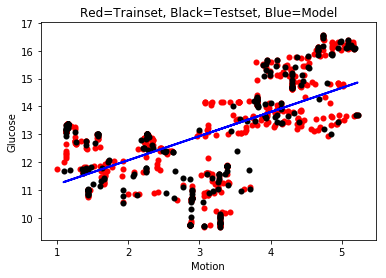

In [109]:
model = LinearRegression(normalize=True)
model.fit(train_motion, train_gluc)
pred_gluc = model.predict(test_motion)
print('mean squared error: ', round(mean_squared_error(test_gluc, pred_gluc),2))
print('variance: ', round(r2_score(test_gluc, pred_gluc),2))

plt.scatter(train_motion, train_gluc,  color='red', linewidth=0.05)
plt.scatter(test_motion, test_gluc,  color='black', linewidth=0.05)
plt.plot(test_motion, pred_gluc, color='blue', linewidth=2)
plt.title("Red=Trainset, Black=Testset, Blue=Model")
plt.xlabel("Motion (hours of walking last 48h)")
plt.ylabel("Glucose (std. dev. )")